# scriptbase topic model

In [11]:
import pandas as pd
import numpy as np

friends = pd.read_csv('friends_text_ratings.csv', index_col=0)
friends.head()

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes,match,text,len in words,len_prep
0,1994,1,1,The One Where Monica Gets a Roommate: The Pilot,22,"Monica and the gang introduce Rachel to the ""r...",James Burrows,8.3,7440,11,tell guy work going guy got wrong nice hump hu...,16424.0,5280.0
1,1994,1,2,The One with the Sonogram at the End,22,Ross finds out his ex-wife is pregnant. Rachel...,James Burrows,8.1,4888,12,guys understand kissing important need know ki...,10709.0,3170.0
2,1994,1,3,The One with the Thumb,22,Monica becomes irritated when everyone likes h...,James Burrows,8.2,4605,13,hi guys good walked subway said ouch said good...,12313.0,3689.0
3,1994,1,4,The One with George Stephanopoulos,22,Joey and Chandler take Ross to a hockey game t...,James Burrows,8.1,4468,14,omnipotent day want world peace hunger good th...,12290.0,4041.0
4,1994,1,5,The One with the East German Laundry Detergent,22,"Eager to spend time with Rachel, Ross pretends...",Pamela Fryman,8.5,4438,15,let big deal big deal amazing reach little man...,12660.0,3859.0


In [12]:
np.mean(friends['len_prep'])

4027.135593220339

## Some checks

In [13]:
# 5 least popular Friends episodes

check = friends.sort_values(by='Stars')

for i in range(5):
    row = check.iloc[i]
    episode = row['Episode Number']
    name = row['Episode_Title']
    season = row['Season']
    summary = row['Summary']
    stars = row['Stars']
    print(f'season {season} episode {episode} , "{name}" rating = {stars} stars: \n\n {summary}\n')

season 4 episode 21 , "The One with the Invitation" rating = 7.2 stars: 

 As Ross and Emily send out wedding invitations, he and Rachel each look back on their relationship together while Joey and Chandler look for a purpose in life.

season 6 episode 20 , "The One with Mac and C.H.E.E.S.E." rating = 7.4 stars: 

 Chandler forgets to write down a message for Joey when the time of his audition for the lead in a TV show is changed.

season 8 episode 19 , "The One with Joey's Interview" rating = 7.5 stars: 

 Joey prepares for his epic interview with Soap Opera Digest, reminiscing about his past acting experiences, his friends and his romantic life.

season 7 episode 21 , "The One with the Vows" rating = 7.5 stars: 

 Monica and Chandler are getting married in four weeks and have to write their vows, but neither has a clue what to say, so they reflect on their past.

season 9 episode 10 , "The One with Christmas in Tulsa" rating = 7.5 stars: 

 Chandler must spend Christmas in Tulsa, whi

In [14]:
# 5 most popular Friends episodes

check = friends.sort_values(by='Stars', ascending=False)

for i in range(5):
    row = check.iloc[i]
    episode = row['Episode Number']
    name = row['Episode_Title']
    season = row['Season']
    summary = row['Summary']
    stars = row['Stars']
    print(f'season {season} episode {episode} , "{name}" rating = {stars} stars: \n\n {summary}\n')

season 10 episode 18 , "The Last One: Part 2" rating = 9.7 stars: 

 Phoebe races Ross to the airport in a bid to stop Rachel from leaving for Paris. Monica and Chandler pack up their apartment ahead of their move to their new house, and Joey buys Chandler a new chick and duck as a leaving present.

season 5 episode 14 , "The One Where Everybody Finds Out" rating = 9.7 stars: 

 When Phoebe finds out about Monica and Chandler, she and Rachel attempt to get them to confess their relationship.

season 10 episode 17 , "The Last One: Part 1" rating = 9.5 stars: 

 Erica gives birth to the baby that Monica and Chandler are adopting. However, there's one small added surprise. Meanwhile, Ross and Rachel sleep together one last time before Rachel leaves ...                See full summary »

season 4 episode 12 , "The One with the Embryos" rating = 9.5 stars: 

 Phoebe's uterus is examined for implantation of the embryos. Meanwhile, a seemingly harmless game between Chandler and Joey against M

## prep

In [15]:
import glob
import random
RND = 12345
random.seed(RND)

class Chunker(object):
    def __init__(self, filenames, metadata, singles_only=False,
                 max_chars_per_book=None, chunk_size=None):
        
        # maximum number of characters to read from the beginning of each book:
        self.max_chars_per_book = max_chars_per_book
        
        # size of the chunks returned (in tokens):
        self.chunk_size = chunk_size
        
        # only return chunks from these files:
        self.filenames = filenames
        
        # include a dictionary with metadata:
        self.meta = meta
        
        # only return texts with a single genre label:
        self.singles_only = singles_only
        
        # only collect genres during the first iteration
        self.first = True

    def __iter__(self):
        if self.first:
            self.genres = []
        
        for filename in self.filenames:
            title = os.path.basename(filename[:-4])
            current_genres = self.meta[title]
            
            if self.singles_only:
                if len(current_genres) > 1:
                    continue

            with open(filename, 'r', encoding='utf-8') as f:
                try:
                    if self.max_chars_per_book:
                        text = f.read()
                        text = text[:self.max_chars_per_book]
                    else:
                        text = f.read()
                except:
                    continue
            
            tokens = text.split()
            
            for i in range(0, len(tokens), self.chunk_size):
                if self.first:
                    self.genres.append(current_genres)
                yield tokens[i:i + self.chunk_size]
                #this also helps for lazy loading because yield goes over it apart
        
        # stop collecting labels after first complete iteration
        self.first = False

In [16]:
n_features = 5000 # number of most common words
n_topics = 30 # number of topics
n_top_words = 60 # number of characteristic words per topic (viz purposes only)
max_df = 0.5 # maximum document frequency
min_df = 100 # minimum document frequency
max_books = 1000 # include all books (None), or a specific number
chunk_size = 4027  # length of the average friends episode (after keeping only ADJ, NOUN & VERB)

In [17]:
path = './scriptbase/scriptbase_texts/*.txt'
filenames = sorted(list(glob.glob(path)))
print(len(filenames))

865


In [18]:
random.seed(RND)
random.shuffle(filenames)
# print(filenames[:10])
# print(len(filenames))

In [19]:
import json
with open('./scriptbase/scriptbase_meta.json', 'r') as f:
    meta = json.loads(f.read())

# for book, genres in list(meta.items())[:20]:
#     print(f"{book} -> {' - '.join(sorted(genres))}")

## NMF

In [22]:
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def identity(x):
    return x

chunks = Chunker(filenames, meta,
                 chunk_size=chunk_size,
                 max_chars_per_book=None)


vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df,
                             max_features=n_features,
                             analyzer=identity)
X = vectorizer.fit_transform(chunks)

from sklearn.decomposition import NMF
nmf = NMF(n_components=300,
          random_state=RND,
          verbose=1, max_iter=100).fit(X) # fit NMF model with TF-IDF feature

import joblib
joblib.dump(nmf,'nmf_scriptbase_friends.sav')
# nmf = joblib.load('nmf_scriptbase_friends.sav')

violation: 1.0
violation: 0.017377815310342618
violation: 0.03424888128639355
violation: 0.030020982409967364
violation: 0.028156768192609843
violation: 0.024619526456115894
violation: 0.026145626434649783
violation: 0.021791828834885334
violation: 0.018169834277832437
violation: 0.016166595934767446
violation: 0.014551106062240672
violation: 0.013387150351391982
violation: 0.011936969619024924
violation: 0.010906125223686287
violation: 0.01019457479946689
violation: 0.009511243234396009
violation: 0.008770653475447282
violation: 0.007937344248197132
violation: 0.00724567440371176
violation: 0.006786609280403516
violation: 0.006389213519839502
violation: 0.005975472178182658
violation: 0.0055309555062315035
violation: 0.005080633178516205
violation: 0.004761075168593545
violation: 0.0044572343790087844
violation: 0.004192444079287163
violation: 0.00402274956505918
violation: 0.0038857553410913083
violation: 0.003714660184164238
violation: 0.0035682380570761538
violation: 0.003413200496

c:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


['nmf_scriptbase_friends.sav']

In [23]:
for topic_idx, topic in enumerate(nmf.components_[:10]):
    top_idxs = np.argsort(topic)[::-1][:10]
    top_words = np.array(vectorizer.get_feature_names())[top_idxs]
    print(f'topic {topic_idx}:', ' - '.join(top_words))

topic 0: dad - kidding - bike - library - signs - busy - grade - hates - brothers - happening
topic 1: mom - cool - wake - parents - bike - mad - older - talked - teacher - grandma
topic 2: cops - cop - jail - bullshit - pissed - tip - rat - bastard - swear - dirty
topic 3: ship - crew - lock - deck - main - event - bridge - star - seconds - signal
topic 4: daddy - feed - mommy - earth - green - cake - folks - meat - strong - survive
topic 5: war - army - fighting - land - peace - military - american - enemy - dawn - paper
topic 6: department - report - records - files - investigation - file - medical - company - missing - mistake
topic 7: pulls - turns - sees - opens - walks - steps - sits - starts - moves - puts
topic 8: film - picture - press - star - screen - scene - cast - shooting - conference - movie
topic 9: soldiers - soldier - weapons - sergeant - training - enemy - double - action - target - wind


c:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [24]:
nmf.verbose = 1
X_ = nmf.transform(X)
print(X_.shape)

violation: 1.0
violation: 0.6616901209988314
violation: 0.32558987674038675
violation: 0.15773372091394883
violation: 0.08517103616517965
violation: 0.052200892615745134
violation: 0.02808659501491611
violation: 0.013198638571766853
violation: 0.007895303016126294
violation: 0.005176482425189328
violation: 0.0029731049045103367
violation: 0.001656201229697663
violation: 0.0010804411515085907
violation: 0.0007011576815664877
violation: 0.0004177945091302745
violation: 0.0002603153407974104
violation: 0.000168170062346716
violation: 0.00010959278694228812
violation: 6.993364502899741e-05
Converged at iteration 20
(1008, 300)


In [25]:
from sklearn.feature_selection import f_classif

genres = [g[0] for g in chunks.genres]
feature_names = vectorizer.get_feature_names()

for genre in set(genres):
    print(f'-> genre {genre}:')
    y = [1 if g == genre else 0 for g in genres]
    # univariate feature selection with F-test for feature scoring
    F, pval = f_classif(X_, y)
    
    # indices of three best topics
    for topic_idx in np.argsort(F)[::-1][:3]:
        topic = np.nan_to_num(nmf.components_[topic_idx])
        words = [feature_names[i] for i in topic.argsort()[:-10:-1]]
        print('   ' + ' - '.join(words))

-> genre thriller:
   cop - partner - basement - busted - bust - department - unit - arrest - admire
   agent - federal - building - evidence - suspect - bodies - field - information - government
   detective - partner - investigation - suspect - evidence - murder - plate - laws - apartment
-> genre musical:
   film - picture - press - star - screen - scene - cast - shooting - conference
   movie - movies - scene - scary - star - camera - audience - character - tits
   italian - client - wine - range - magazine - weapon - mountains - reasons - american
-> genre western:
   horses - trail - stage - fellow - lookin - fix - folks - fair - letters
   horse - pounds - horses - riding - medicine - farm - gentleman - land - stands
   judge - law - justice - county - central - fool - politics - arrest - hide
-> genre animation:
   travel - papers - grandmother - child - bat - convince - bike - stretch - memory
   plant - e - earth - wall - dancing - operation - negative - space - deck
   sourc

c:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
import pandas as pd
nmf.verbose = 0

texts = [value.split() for value in friends.text.values]

scores = nmf.transform(vectorizer.transform(texts))  # transform the HP chapters according to the fitted NMF model
scores.shape
# print(scores)

(236, 300)

In [27]:
df_scores = pd.DataFrame(scores, columns=[f't{i+1}' for i in range(scores.shape[1])])
friends2 = friends.join(df_scores)
friends2.head()

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes,match,...,t291,t292,t293,t294,t295,t296,t297,t298,t299,t300
0,1994,1,1,The One Where Monica Gets a Roommate: The Pilot,22,"Monica and the gang introduce Rachel to the ""r...",James Burrows,8.3,7440,11,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,1994,1,2,The One with the Sonogram at the End,22,Ross finds out his ex-wife is pregnant. Rachel...,James Burrows,8.1,4888,12,...,0.0,0.004784,0.007564,0.0,0.000000,0.0,0.000000,0.0,0.004770,0.0
2,1994,1,3,The One with the Thumb,22,Monica becomes irritated when everyone likes h...,James Burrows,8.2,4605,13,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,1994,1,4,The One with George Stephanopoulos,22,Joey and Chandler take Ross to a hockey game t...,James Burrows,8.1,4468,14,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.019966,0.0
4,1994,1,5,The One with the East German Laundry Detergent,22,"Eager to spend time with Rachel, Ross pretends...",Pamela Fryman,8.5,4438,15,...,0.0,0.000000,0.000000,0.0,0.008575,0.0,0.078775,0.0,0.000000,0.0


In [28]:
from operator import itemgetter
from scipy.stats import kendalltau

ranks = range(1, len(friends2.index)+1)
tau_scores = []
for col in [f't{i+1}' for i in range(scores.shape[1])]:
    tau, p = kendalltau(ranks, friends2[col].tolist())
    tau_scores.append((col, tau))
    
tau_scores.sort(key=itemgetter(1))
nb = 6
top, bottom = tau_scores[:nb], tau_scores[-nb:]
print(tau_scores[:10]) # print 10 topics with lowest Tau score

[('t155', -0.17529413766991264), ('t175', -0.14870978321066022), ('t209', -0.1416367697234404), ('t56', -0.13578646611863193), ('t218', -0.13464628715686772), ('t33', -0.13179482610118542), ('t287', -0.1273863510723506), ('t91', -0.12696138386234698), ('t18', -0.12594495209849135), ('t169', -0.12414185675412832)]


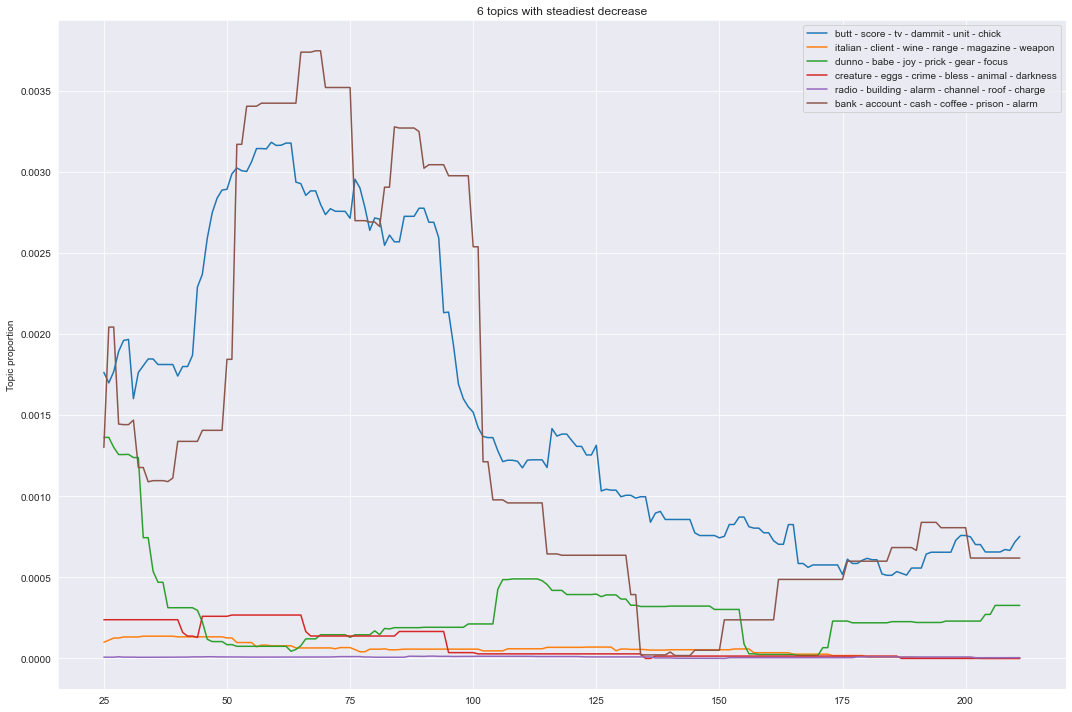

In [29]:
import matplotlib.pyplot as plt

import seaborn as sb
feature_names = vectorizer.get_feature_names_out()
fig = plt.figure(figsize=(15, 10))
sb.set_style("darkgrid")
for (feat, tau), col in zip(top, sb.color_palette("Set1")[:nb]):
    topic = nmf.components_[int(feat.replace('t', '')) - 1, :]
    words = [feature_names[i] for i in topic.argsort()[:-6-1:-1]]
    label = ' - '.join(words)
    friends2[feat].rolling(window=50, center=True).mean().plot(label=label)
plt.xlabel('', fontsize=10)
plt.ylabel('Topic proportion', fontsize=10)
plt.title(f'{nb} topics with steadiest decrease')
plt.tight_layout()
plt.legend();

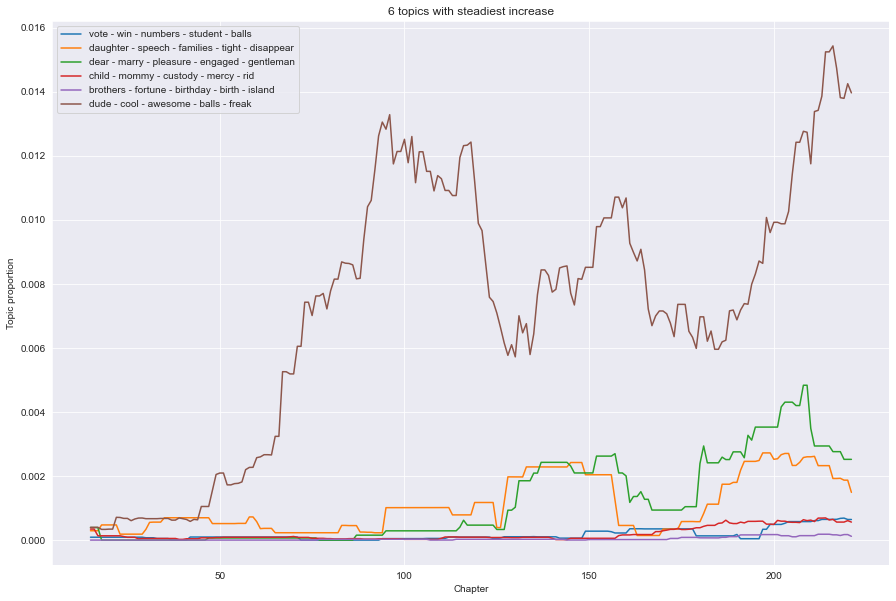

In [30]:
fig = plt.figure(figsize=(15, 10))
sb.set_style("darkgrid")
for (feat, tau), col in zip(bottom, sb.color_palette("Set1")[:nb]):
    topic = nmf.components_[int(feat.replace('t', '')) - 1, :]
    words = [feature_names[i] for i in topic.argsort()[:-5-1:-1]]
    label = ' - '.join(words)
    friends2[feat].rolling(window=30, center=True).mean().plot(label=label)
plt.xlabel('Chapter', fontsize=10)
plt.ylabel('Topic proportion', fontsize=10)
plt.title(f'{nb} topics with steadiest increase')
plt.legend();

In [31]:
#25 most predictive topics

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

feature_names = vectorizer.get_feature_names_out()
X = friends2.drop(columns=friends.columns.tolist())


y = friends2.Stars
# univariate feature selection with F-test for feature scoring
F, pval = f_regression(X, y)
    
    
for topic_idx in np.argsort(F)[::-1][:25]:
    topic = np.nan_to_num(nmf.components_[topic_idx])
    words = [feature_names[i] for i in topic.argsort()[:-10:-1]]
    print(f't{topic_idx}: ' + ' - '.join(words))

t16: plane - flight - pilot - fly - flying - land - crew - control - flew
t277: summer - girlfriend - beach - crap - loved - grade - dreams - card - cards
t112: source - path - destroy - remains - machines - weapon - planned - hunting - fool
t132: flight - papers - gate - hurry - nut - assure - nail - letting - violence
t218: prison - sentence - guards - court - cell - innocent - society - brain - outside
t199: meaning - attention - ruin - pressure - won - strength - proceed - result - m
t286: talkin - gettin - comin - tryin - folks - lookin - round - chicken - hits
t47: writer - write - writing - wrote - written - character - coat - pathetic - research
t36: camera - trunk - beef - handsome - swear - crew - ear - wallet - traffic
t83: bug - planet - belt - federal - battle - citizen - cap - service - sport
t197: shoe - junk - events - credit - pal - president - nuts - citizen - pause
t19: grace - bike - trees - teach - trunk - spirit - dawn - meat - keys
t251: river - stole - tree - bo

### Predictions 
#### setting baselines

In [47]:
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.model_selection import train_test_split

X = friends2.drop(columns=friends.columns.tolist())
y = friends2.Stars

cv = LeaveOneOut()

dummy_regr = DummyRegressor(strategy="mean")

scores = cross_val_score(dummy_regr, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))


-0.3113667508113955 0.24655333378118335


In [48]:

X = friends['text']
y = friends2.Stars

cv = LeaveOneOut()

reg = LinearRegression()
vect = TfidfVectorizer()

pipe = make_pipeline(vect, reg)

scores = cross_val_score(pipe, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))


-0.3192444127354182 0.27835599860686666


In [44]:
friends.columns

Index(['Year_of_prod', 'Season', 'Episode Number', 'Episode_Title', 'Duration',
       'Summary', 'Director', 'Stars', 'Votes', 'match', 'text',
       'len in words', 'len_prep'],
      dtype='object')

#### predictions with topics

In [49]:
#all features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

feature_names = vectorizer.get_feature_names_out()
X = friends2.drop(columns=friends.columns.tolist())
y = friends2.Stars

reg = LinearRegression()

scores = cross_val_score(reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-850297878.6328871 12600247522.78854


In [50]:
#25 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]

feature_names = vectorizer.get_feature_names_out()
X = friends2[Best]
y = friends2.Stars

reg = LinearRegression()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.34132509405760747 0.25981946437219205


In [51]:
#10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]

feature_names = vectorizer.get_feature_names_out()
Xble = friends2.drop(columns=friends.columns.tolist())
X = Xble[Best]
y = friends2.Stars

reg = LinearRegression()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.3248553749955487 0.25182946175627935


In [37]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]
xtra = ['Year_of_prod', 'Votes', 'Duration']

cols = Best+xtra

cols.append('Stars')

scal = StandardScaler()

corrM = friends2[cols].corr()
 
corrM


,t16,t277,t112,t132,t218,t199,t286,t47,t36,t83,Year_of_prod,Votes,Duration,Stars
t16,1.000000,-0.014455,-0.029551,-0.025996,-0.027678,0.009011,0.053604,-0.004372,-0.023462,-0.006622,0.021521,0.009886,-0.026992,-0.020178
t277,-0.014455,1.000000,-0.018339,0.023381,-0.016775,0.063967,0.081502,-0.023429,-0.017722,-0.012675,0.097680,-0.046230,-0.021515,-0.048060
t112,-0.029551,-0.018339,1.000000,-0.031847,0.025494,-0.031876,-0.038401,-0.027571,-0.033369,0.144186,-0.062688,0.019969,-0.002602,-0.100397
t132,-0.025996,0.023381,-0.031847,1.000000,-0.048800,-0.015523,-0.030603,-0.049270,0.000996,-0.050110,0.155734,-0.079285,-0.016880,0.006282
t218,-0.027678,-0.016775,0.025494,-0.048800,1.000000,0.088489,-0.047843,0.015802,0.019948,-0.032708,-0.072616,-0.003796,-0.019194,-0.049427
t199,0.009011,0.063967,-0.031876,-0.015523,0.088489,1.000000,0.027496,-0.019696,0.042358,-0.064882,0.062470,0.021223,-0.050202,0.095366
t286,0.053604,0.081502,-0.038401,-0.030603,-0.047843,0.027496,1.000000,-0.034726,0.010496,-0.050879,0.181144,-0.068861,0.002210,0.026279
t47,-0.004372,-0.023429,-0.027571,-0.049270,0.015802,-0.019696,-0.034726,1.000000,0.005651,-0.008874,0.024298,0.055576,-0.027876,0.092912
t36,-0.023462,-0.017722,-0.033369,0.000996,0.019948,0.042358,0.010496,0.005651,1.000000,-0.040097,0.021812,-0.043289,-0.027115,-0.005756
t83,-0.006622,-0.012675,0.144186,-0.050110,-0.032708,-0.064882,-0.050879,-0.008874,-0.040097,1.000000,0.125575,-0.051266,0.140194,-0.005535


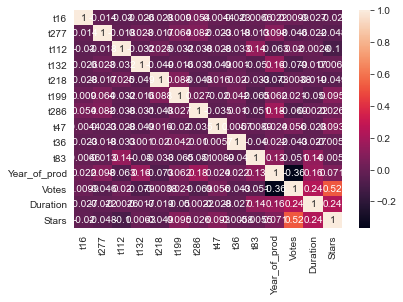

In [38]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(corrM, annot=True)
plt.show()

In [39]:
# print(friends2.Director.value_counts())

lst = ['Gary Halvorson',        
'Kevin Bright',          
'Michael Lembeck',       
'James Burrows',           
'Gail Mancuso',           
'Peter Bonerz',            
'David Schwimmer',         
'Ben Weiss']

def direr(wow):
    if wow not in lst:
        wow = wow.replace(wow,'Other')
    return wow

friends2['Director'] = friends2['Director'].apply(direr)

print(friends2.Director.value_counts())

Gary Halvorson     54
Kevin Bright       54
Other              43
Michael Lembeck    24
James Burrows      15
Gail Mancuso       14
Peter Bonerz       12
David Schwimmer    10
Ben Weiss          10
Name: Director, dtype: int64


In [52]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[1::-1]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = LinearRegression()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.30414062232751493 0.24315648926089023


In [41]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = LinearRegression()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4601473462865432 0.059412119625408294


In [42]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = LinearRegression()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.42238689134705404 0.04159380506501158


In [31]:
# import joblib
# filename = 'nmf_books_friends.sav'
# joblib.dump(nmf, filename)

['nmf_books_friends.sav']

### SVR

In [43]:
from sklearn.svm import SVR

feature_names = vectorizer.get_feature_names_out()
X = friends2.drop(columns=friends.columns.tolist())
y = friends2.Stars

reg = SVR()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4209709651377519 0.04900406499839548


In [51]:
from sklearn.svm import SVR

Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]

feature_names = vectorizer.get_feature_names_out()
X = friends2[Best]
y = friends2.Stars

reg = SVR()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4269642548856371 0.06804596026969317


In [78]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]

feature_names = vectorizer.get_feature_names_out()
X = friends2[Best]
y = friends2.Stars

reg = SVR()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.41355260347536077 0.054011321600815024


In [79]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[1::-1]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = SVR()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4229000071383643 0.06739912152089038


In [80]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = SVR()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4256167722242978 0.053832344041550656


In [81]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = SVR()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4243136464831898 0.051222479025645556


### gradient boosting

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

feature_names = vectorizer.get_feature_names_out()
X = friends2.drop(columns=friends.columns.tolist())
y = friends2.Stars

reg = GradientBoostingRegressor()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4243307529303612 0.05454752391623509


In [72]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]

feature_names = vectorizer.get_feature_names_out()
X = friends2[Best]
y = friends2.Stars

reg = GradientBoostingRegressor()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4743865021548091 0.05309363102278743


In [73]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]

feature_names = vectorizer.get_feature_names_out()
X = friends2[Best]
y = friends2.Stars

reg = GradientBoostingRegressor()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4626873499655191 0.05295926483927544


In [82]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[1::-1]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = GradientBoostingRegressor()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4519760133963449 0.09862278303568002


In [76]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = GradientBoostingRegressor()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4645101793031987 0.05817339521301511


In [77]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = GradientBoostingRegressor()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.42918556542695996 0.06242421122639609
